In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=1)


class Vector:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y

    def __str__(self):
        return f"({self.x}, {self.y})"

    def __eq__(self, other):
        return (self.x == other.x) and (self.y == other.y)

    def __add__(self, other):
        return Vector(self.x + other.x, self.y + other.y)

    def __sub__(self, other):
        return Vector(self.x - other.x, self.y - other.y)

    def __truediv__(self, val):
        return Vector(self.x / val, self.y / val)

    def __iter__(self):
        return iter((self.x, self.y))
    
    def copy(self):
        return Vector(self.x, self.y)

    def clip_update(self, new_vec, bounds):
        if new_vec.x < 0:
            self.x = 0
        elif new_vec.x >= bounds.x:
            self.x = bounds.x - 1
        else:
            self.x = new_vec.x

        if new_vec.y < 0:
            self.y = 0
        elif new_vec.y >= bounds.y:
            self.y = bounds.y - 1
        else:
            self.y = new_vec.y

In [2]:
class FrozenLake:
    def __init__(self):
        # self.environment = np.array([
        #     ['S', 'F', 'F', 'F'],
        #     ['F', 'O', 'F', 'O'],
        #     ['F', 'F', 'F', 'O'],
        #     ['O', 'F', 'F', 'G'],
        # ])

        self.environment = np.array([
            ['S','F','F','F','O','F'],
            ['F','F','F','F','F','F'],
            ['F','F','O','O','F','F'],
            ['F','F','O','O','F','F'],
            ['F','F','O','O','F','F'],
            ['F','F','O','O','F','F'],
            ['F','F','F','F','F','F'],
            ['0','F','F','F','F','G'],
        ])

        self.size = Vector(*self.environment.shape)
        self.termination_states = []
        
        for y in range(self.environment.shape[0]):
            for x in range(self.environment.shape[1]):
                entry = self.environment[y, x]
                pos = Vector(x, y)

                if entry == 'S':
                    self.start_pos = pos
                elif entry == 'O':
                    self.termination_states.append(pos)
                elif entry == 'G':
                    self.goal_pos = pos
                    self.termination_states.append(pos)

        self.actions = {
            0: Vector(0, -1), # N
            1: Vector(1, 0),  # E
            2: Vector(-1, 0), # W
            3: Vector(0, 1),  # S
        }

        # self.drift_dir_p = {
        #     'front': 0.7,
        #     'left': 0.125,
        #     'right': 0.125,
        #     'back': 0.05
        # }

        self.drift_dir_p = {
            'front': 1.0,
            'left': 0.0,
            'right': 0.0,
            'back': 0.0
        }

    def get_drift_dir(self, agent_action):
        p = np.random.rand()
        p_ = self.drift_dir_p['front']

        x, y = agent_action
        if p < p_: return agent_action
        
        p_ += self.drift_dir_p['left']
        if p < p_: return Vector(-y, x)

        p_ += self.drift_dir_p['right']
        if p < p_: return Vector(y, -x)
        
        return Vector(-x, -y)

    def get_state_transition(self, agent_pos, agent_action):
        new_pos = agent_pos + self.get_drift_dir(agent_action)
        agent_pos.clip_update(new_pos, bounds=self.size)

        return agent_pos

    def agent_terminated(self, agent_pos):
        return agent_pos in self.termination_states
    
    def get_reward(self, agent_pos):
        if agent_pos == self.goal_pos:
            return 10
        elif agent_pos in self.termination_states:
            return -10
    
        return -1

In [3]:
class Agent:
    def __init__(self, world):
        self.world = world

        self.pos = Vector(0, 0)
        self.actions = self.world.actions

        # Agent's model
        self.epsilon = 0.1  # for epsilon-greedy function
        self.action_value = np.zeros(
            (self.world.size.x, self.world.size.y, len(self.actions))
        )

    def init(self):
        self.pos = self.world.start_pos.copy()

    def get_state(self):
        return (self.pos.x, self.pos.y)

    def sample_action(self):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(len(self.actions))
        else:
            state = tuple(self.get_state())
            action = np.argmax(self.action_value[state])

        return int(action)

    def get_state_action(self, action):
        state = self.get_state()
        return tuple(list(state) + [action])

    def update_state(self, action):
        # Returns reward

        self.pos = self.world.get_state_transition(self.pos, self.actions[action])
        reward = self.world.get_reward(self.pos)

        return self.pos, reward

[['<' '^' '^' '^' '^' '^']
 ['<' '^' '^' '^' '^' '^']
 ['<' '^' '^' '^' '^' '^']
 ['<' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']]
[['v' '<' '>' '^' '^' '^']
 ['v' '^' '<' '^' '^' '^']
 ['>' '>' '^' '^' '^' '^']
 ['<' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']]
[['v' 'v' 'v' '^' '^' '^']
 ['^' '<' '<' '>' '^' '^']
 ['^' '>' '^' '^' '^' '^']
 ['v' '>' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']]
[['^' '>' 'v' '^' '^' '^']
 ['>' '<' 'v' '>' '^' '^']
 ['>' '>' '^' '^' '^' '^']
 ['v' 'v' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['v' '>' '<' '^' '^' '^']
 ['>' '>' '>' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']]
[['>' '>' 'v' '^' '^' '^']
 ['v' '<' 'v' '>' '^' '^']
 ['<' '>' '^' '^' '^' '^']
 ['^' '>' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^

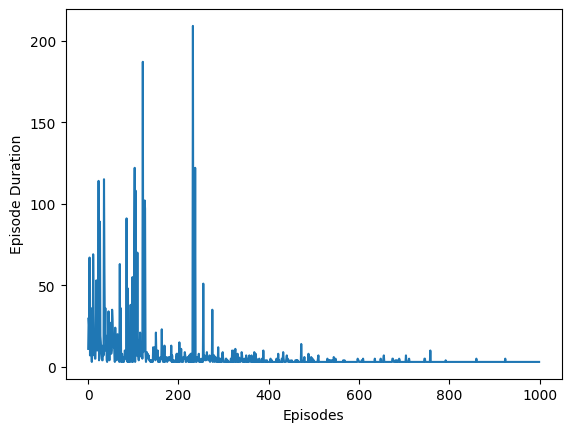

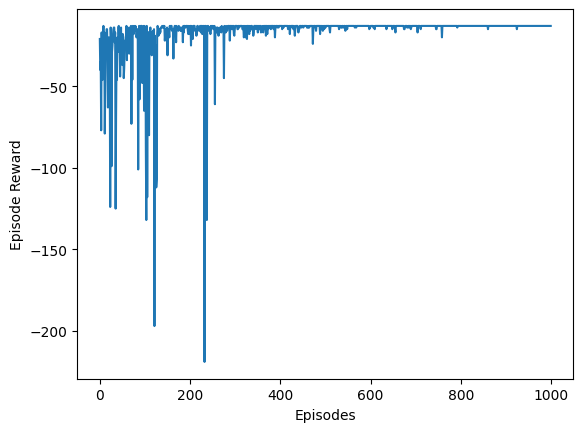

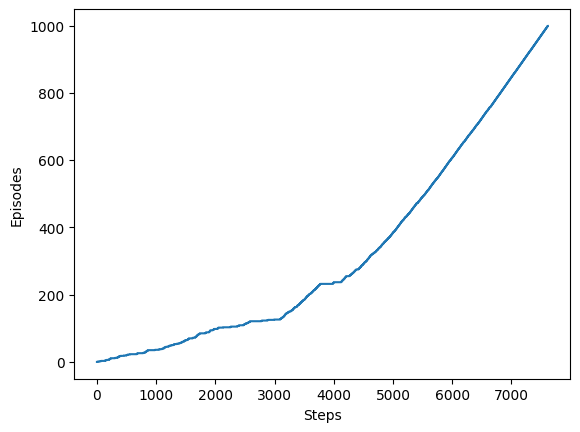

[['<' '^' '^' '^' '^' '^']
 ['<' '^' '^' '^' '^' '^']
 ['<' '^' '^' '^' '^' '^']
 ['<' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']]
[['>' '>' '<' '^' '^' '^']
 ['v' '^' '>' '^' '^' '^']
 ['v' '>' '^' '^' '^' '^']
 ['<' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']]
[['>' 'v' '<' '^' '^' '^']
 ['^' '^' '<' '^' '^' '^']
 ['v' '>' '^' '^' '^' '^']
 ['<' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']]
[['v' 'v' '<' '^' '^' '^']
 ['v' 'v' '<' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['v' '<' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']]
[['v' '^' '>' '<' '^' '^']
 ['>' '>' 'v' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^']
 ['v' '<' '^' '^' '^' '^']
 ['^' '^' '^' '^' '^' '^

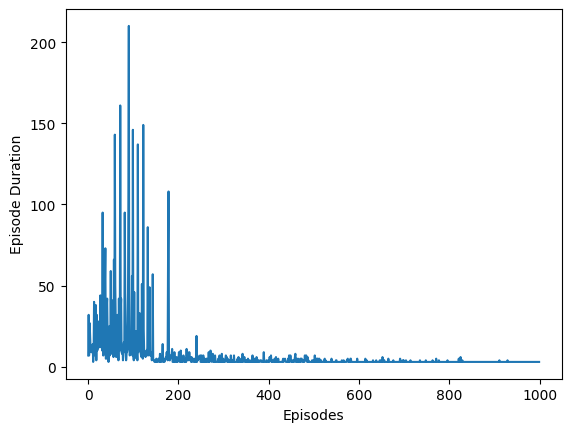

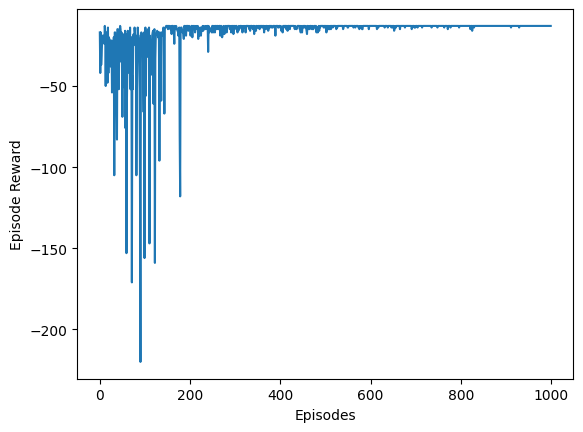

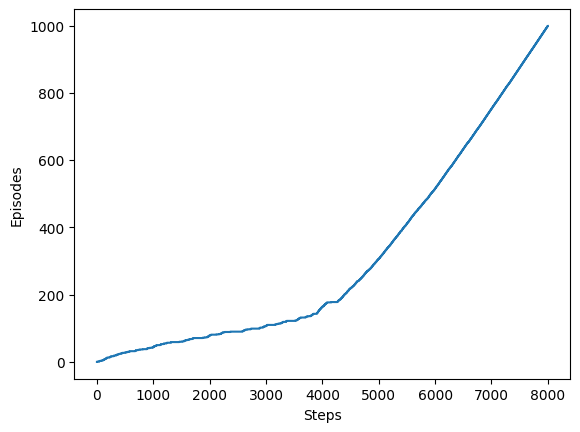

In [4]:
class Trainer():
    def __init__(self, cfg):
        self.world = cfg['world']
        self.agent = Agent(self.world)

        self.max_episodes = cfg['max_episodes']
        self.max_ep_duration = 1000

        self.gamma = cfg['gamma']
        self.alpha = cfg['alpha']  # learning rate

        self.mapping_dict = {
            0: '^',
            1: '>',
            2: '<',
            3: 'v'
        }

        # Logging
        self.episode_durations = []
        self.episode_steps = []
        self.episode_rewards = []


    def sarsa_train(self):
        steps = 0
        for episode in range(self.max_episodes):
            self.agent.init()
            
            # Choose A from S using policy derived from Q
            action = self.agent.sample_action()
            episode_duration = 0
            episode_reward = 0
            while True:
                state_action = self.agent.get_state_action(action)

                # Take action A, observe R, S'
                _, reward = self.agent.update_state(action)
                episode_reward += reward

                # Choose A' from S' using policy derived from Q
                new_action = self.agent.sample_action()
                new_state_action = self.agent.get_state_action(new_action)

                # Updating Q
                returns = self.agent.action_value[new_state_action]
                curr_value = self.agent.action_value[state_action]

                self.agent.action_value[state_action] = \
                    curr_value + self.alpha * (reward + self.gamma * returns - curr_value)
                
                self.episode_steps.append((episode, steps))
                steps += 1

                if self.world.agent_terminated(self.agent.pos) \
                    or episode_duration > self.max_ep_duration:
                    self.episode_durations.append(episode_duration)
                    self.episode_rewards.append(episode_reward)

                    iter_frac = episode / self.max_episodes
                    poly_decay = (1 - iter_frac) ** 2
                    self.agent.epsilon = 0.5 * poly_decay

                    best_actions = np.argmax(self.agent.action_value, axis=-1)
                    vectorized_mapping = np.vectorize(self.mapping_dict.get)
                    print(vectorized_mapping(best_actions))

                    break
                else:
                    episode_duration += 1
                    action = new_action

    def q_learning_train(self):
        steps = 0
        for episode in range(self.max_episodes):
            self.agent.init()
            
            # Choose A from S using policy derived from Q
            episode_duration = 0
            episode_reward = 0
            while True:
                action = self.agent.sample_action()
                state_action = self.agent.get_state_action(action)

                # Take action A, observe R, S'
                _, reward = self.agent.update_state(action)
                episode_reward += reward

                # Updating Q
                returns = np.max(self.agent.action_value[self.agent.get_state()])
                curr_value = self.agent.action_value[state_action]

                self.agent.action_value[state_action] = \
                    curr_value + self.alpha * (reward + self.gamma * returns - curr_value)
                
                self.episode_steps.append((episode, steps))
                steps += 1

                if self.world.agent_terminated(self.agent.pos) \
                    or episode_duration > self.max_ep_duration:
                    self.episode_durations.append(episode_duration)
                    self.episode_rewards.append(episode_reward)

                    iter_frac = episode / self.max_episodes
                    poly_decay = (1 - iter_frac) ** 2
                    self.agent.epsilon = 0.5 * poly_decay

                    best_actions = np.argmax(self.agent.action_value, axis=-1)
                    vectorized_mapping = np.vectorize(self.mapping_dict.get)
                    print(vectorized_mapping(best_actions))

                    break
                else:
                    episode_duration += 1

    def policy_iteration(self):
        pass


    def train(self, mode):
        if mode == 'sarsa':
            self.sarsa_train()
        elif mode == 'q-learning':
            self.q_learning_train()
        else:
            raise NotImplementedError
        
    def train_and_plot(self, mode):
        self.train(mode)

        plt.plot(np.arange(self.max_episodes), self.episode_durations)
        # plt.yscale('log')
        plt.xlabel('Episodes'); plt.ylabel('Episode Duration')
        plt.show()

        plt.plot(np.arange(self.max_episodes), self.episode_rewards)
        plt.xlabel('Episodes'); plt.ylabel('Episode Reward')
        plt.show()

        episodes = [e[0] for e in self.episode_steps]
        steps = [e[1] for e in self.episode_steps]

        _len = min(len(episodes), len(steps))
        plt.plot(steps[:_len], episodes[:_len])
        plt.xlabel('Steps'); plt.ylabel('Episodes')
        plt.show()



frozen_lake = FrozenLake()

cfg = {
    'world': frozen_lake,
    'max_episodes': 1000,
    'gamma': 0.99,
    'alpha': 0.5
}

if True:
    Trainer(cfg).train_and_plot(mode='sarsa')
    Trainer(cfg).train_and_plot(mode='q-learning')